# Keras Quickstart for TPSMAY22

This notebook shows how to train a Keras model with minimal feature engineering. For the corresponding EDA, see the [separate EDA notebook](https://www.kaggle.com/code/ambrosm/tpsmay22-eda-which-makes-sense).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats
import math

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import CalibrationDisplay

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, InputLayer, Add

plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])

In [2]:
# Plot training history
def plot_history(history, *, n_epochs=None, plot_lr=False, title=None, bottom=None, top=None):
    """Plot (the last n_epochs epochs of) the training history
    
    Plots loss and optionally val_loss and lr."""
    plt.figure(figsize=(15, 6))
    from_epoch = 0 if n_epochs is None else max(len(history['loss']) - n_epochs, 0)
    
    # Plot training and validation losses
    plt.plot(np.arange(from_epoch, len(history['loss'])), history['loss'][from_epoch:], label='Training loss')
    try:
        plt.plot(np.arange(from_epoch, len(history['loss'])), history['val_loss'][from_epoch:], label='Validation loss')
        best_epoch = np.argmin(np.array(history['val_loss']))
        best_val_loss = history['val_loss'][best_epoch]
        if best_epoch >= from_epoch:
            plt.scatter([best_epoch], [best_val_loss], c='r', label=f'Best val_loss = {best_val_loss:.5f}')
        if best_epoch > 0:
            almost_epoch = np.argmin(np.array(history['val_loss'])[:best_epoch])
            almost_val_loss = history['val_loss'][almost_epoch]
            if almost_epoch >= from_epoch:
                plt.scatter([almost_epoch], [almost_val_loss], c='orange', label='Second best val_loss')
    except KeyError:
        pass
    if bottom is not None: plt.ylim(bottom=bottom)
    if top is not None: plt.ylim(top=top)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower left')
    if title is not None: plt.title(title)
        
    # Plot learning rate
    if plot_lr and 'lr' in history:
        ax2 = plt.gca().twinx()
        ax2.plot(np.arange(from_epoch, len(history['lr'])), np.array(history['lr'][from_epoch:]), color='g', label='Learning rate')
        ax2.set_ylabel('Learning rate')
        ax2.legend(loc='upper right')
        
    plt.show()
    

# Feature engineering

We read the data and apply minimal feature engineering: We only split the `f_27` string into ten separate features as described in the [EDA](https://www.kaggle.com/code/ambrosm/tpsmay22-eda-which-makes-sense), and we count the unique characters in the string.

In [3]:
train = pd.read_csv('../input/tabular-playground-series-may-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-may-2022/test.csv')
for df in [train, test]:
    for i in range(10):
        df[f'ch{i}'] = df.f_27.str.get(i).apply(ord) - ord('A')
    # Next feature is from https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model
    df["unique_characters"] = df.f_27.apply(lambda s: len(set(s)))
features = [f for f in test.columns if f != 'id' and f != 'f_27']
test[features].head(2)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,unique_characters
0,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,0,...,0,0,0,1,0,3,11,0,2,5
1,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,4,...,5,0,1,1,0,4,6,2,1,6


# Cross-validation

For cross-validation, we use a simple KFold with five splits. It has turned out that the scores of the five splits are very similar so that I usually run only the first split. This one split is good enough to evaluate the model.

I like to first train the model with early stopping to see what are good initial and final learning rates and the number of epochs, and then I switch to cosine learning rate decay. You can switch back to early stopping anytime by setting the parameter `USE_PLATEAU`.

41 features


2022-05-01 09:35:55.635320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 09:35:55.712665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 09:35:55.713591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 09:35:55.715129: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Training loss:            0.093
Fold 0.0 | 01:30 | AUC: 0.994


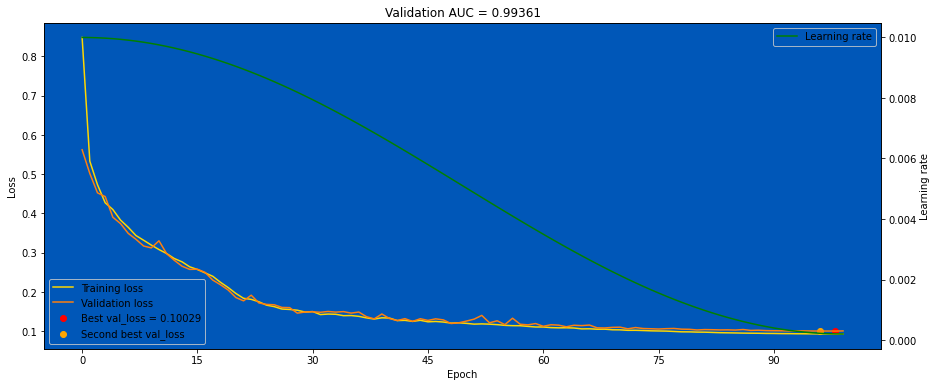

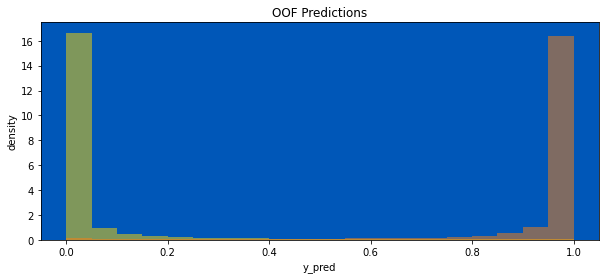

OOF AUC:                       0.994
CPU times: user 1min 48s, sys: 9.87 s, total: 1min 58s
Wall time: 1min 32s


In [4]:
%%time
# Cross-validation of the classifier

EPOCHS = 200
EPOCHS_COSINEDECAY = 100
VERBOSE = 0 # set to 0 for less output, or to 2 for more output
DIAGRAMS = True
USE_PLATEAU = False
INFERENCE = False
BATCH_SIZE = 4096


def my_model():
    """Simple sequential neural network with three hidden layers.
    
    Returns a (not yet compiled) instance of tensorflow.keras.models.Model.
    """
    activation = 'swish' # or 'relu'
    inputs = Input(shape=(len(features)))
    x = Dense(64, #kernel_regularizer=tf.keras.regularizers.l2(1e-6),
              use_bias=True,
              activation='swish',
             )(inputs)
    x = Dense(64, #kernel_regularizer=tf.keras.regularizers.l2(1e-6),
              use_bias=True,
              activation='swish',
             )(inputs)
    x = Dense(16, #kernel_regularizer=tf.keras.regularizers.l2(1e-6),
              use_bias=True,
              activation='swish',
             )(x)
    x = Dense(1, #kernel_regularizer=tf.keras.regularizers.l2(1e-6),
              use_bias=True,
              activation='sigmoid',
             )(x)
    model = Model(inputs, x)
    return model


def fit_model(X_tr, y_tr, X_va=None, y_va=None, run=0):
    """Scale the data, fit a model, plot the training history and optionally validate the model
    
    Returns a trained instance of tensorflow.keras.models.Model.
    
    As a side effect, updates y_va_pred, history_list and score_list.
    """
    global y_va_pred
    start_time = datetime.datetime.now()
    
    if X_va is not None:
        validation_data = (X_va, y_va)
    else:
        validation_data = None

    # Define the learning rate schedule and EarlyStopping
    lr_start=0.01
    if USE_PLATEAU and X_va is not None: # use early stopping
        epochs = EPOCHS
        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.7, 
                               patience=4, verbose=VERBOSE)
        es = EarlyStopping(monitor="val_loss",
                           patience=12, 
                           verbose=1,
                           mode="min", 
                           restore_best_weights=True)
        callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

    else: # use cosine learning rate decay rather than early stopping
        epochs = EPOCHS_COSINEDECAY
        lr_end=0.0002
        def cosine_decay(epoch):
            if epochs > 1:
                w = (1 + math.cos(epoch / (epochs-1) * math.pi)) / 2
            else:
                w = 1
            return w * lr_start + (1 - w) * lr_end

        lr = LearningRateScheduler(cosine_decay, verbose=0)
        callbacks = [lr, tf.keras.callbacks.TerminateOnNaN()]
        
    # Construct and compile the model
    model = my_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_start),
                  #metrics='acc',
                  loss=tf.keras.losses.BinaryCrossentropy())
    #model.compile(optimizer=tf.keras.optimizers.SGD(), loss='mse')

    # Train the model
    history = model.fit(X_tr, y_tr, 
                        validation_data=validation_data, 
                        epochs=epochs,
                        verbose=VERBOSE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)

    history_list.append(history.history)
    callbacks, es, lr, history = None, None, None, None
    print(f"Training loss:            {history_list[-1]['loss'][-1]:.3f}")
    
    if X_va is not None:
        # Inference for validation
        y_va_pred = model.predict(X_va)
        #oof_list[run][val_idx] = y_va_pred
        
        # Evaluation: Execution time and AUC
        score = roc_auc_score(y_va, y_va_pred)
        print(f"Fold {run}.{fold} | {str(datetime.datetime.now() - start_time)[-12:-7]}"
              f" | AUC: {score:.3f}")
        score_list.append(score)
        
        if DIAGRAMS and fold == 0 and run == 0:
            # Plot training history
            plot_history(history_list[-1], title=f"Validation AUC = {score:.5f}",
                         plot_lr=True, n_epochs=110)

            # Plot y_true vs. y_pred
            plt.figure(figsize=(10, 4))
            plt.hist(y_va_pred[y_va == 0], bins=np.linspace(0, 1, 21), alpha=0.5, density=True)
            plt.hist(y_va_pred[y_va == 1], bins=np.linspace(0, 1, 21), alpha=0.5, density=True)
            plt.xlabel('y_pred')
            plt.ylabel('density')
            plt.title('OOF Predictions')
            plt.show()

    return model


print(f"{len(features)} features")
history_list = []
score_list = []
kf = KFold(n_splits=5)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = train.iloc[idx_tr].target
    y_va = train.iloc[idx_va].target
    
    fit_model(X_tr, y_tr, X_va, y_va)
    break # we only need the first fold

print(f"OOF AUC:                       {np.mean(score_list):.3f}")

# Three diagrams for model evaluation

We plot the ROC curve just because it looks nice. The area under the red curve is the score of our model.


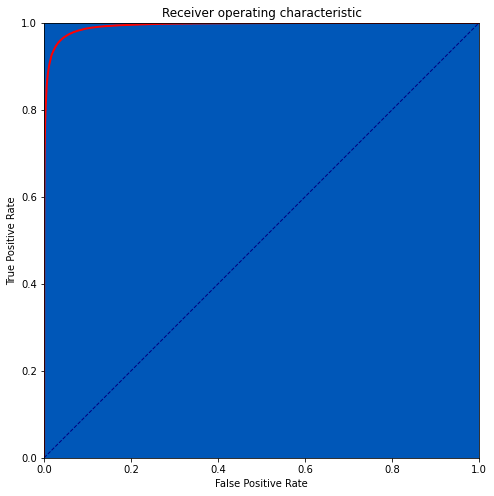

In [5]:
# Plot the roc curve for the last fold
def plot_roc_curve(y_va, y_va_pred):
    plt.figure(figsize=(8, 8))
    fpr, tpr, _ = roc_curve(y_va, y_va_pred)
    plt.plot(fpr, tpr, color='r', lw=2)
    plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
    plt.gca().set_aspect('equal')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.show()

plot_roc_curve(y_va, y_va_pred)

Second, we plot a histogram of the out-of-fold predictions. Many predictions are near 0.0 or near 1.0; this means that in many cases the classifier's predictions have high confidence:

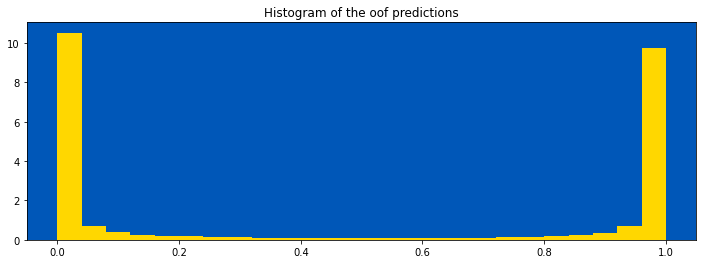

In [6]:
plt.figure(figsize=(12, 4))
plt.hist(y_va_pred, bins=25, density=True)
plt.title('Histogram of the oof predictions')
plt.show()


Finally, we plot the calibration curve. The curve here is almost a straight line, which means that the predicted probabilities are almost exact: 

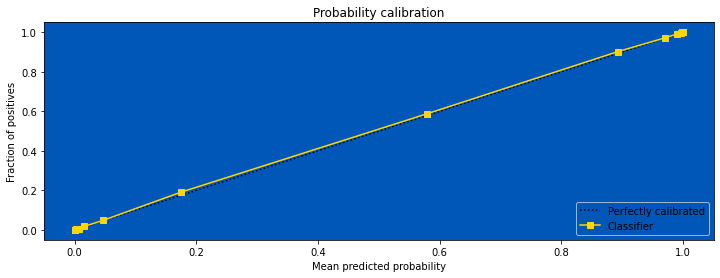

In [7]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, y_va_pred, n_bins=20, strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()

# Submission

For the submission, we re-train the model on the complete training data with several different seeds and then submit the mean of the predicted ranks.

In [8]:
# Create submission
print(f"{len(features)} features")

X_tr = train[features]
y_tr = train.target

pred_list = []
for seed in range(10):
    model = fit_model(X_tr, y_tr, run=seed)
    model.fit(X_tr.values, y_tr)
    pred_list.append(scipy.stats.rankdata(model.predict(test[features].values, batch_size=BATCH_SIZE)))
    print(f"{seed:2}", pred_list[-1])
print()
submission = test[['id']].copy()
submission['target'] = np.array(pred_list).mean(axis=0)
submission.to_csv('submission.csv', index=False)
submission

41 features
Training loss:            0.099
28125/28125 [==============================] - 64s 2ms/step - loss: 0.1107
 0 [649658.5 626451.5  20435.  ... 335231.  271718.   23421. ]
Training loss:            0.089
28125/28125 [==============================] - 65s 2ms/step - loss: 0.0992
 1 [530521.5 572408.    7988.  ... 378659.  234598.    5127. ]
Training loss:            0.088
28125/28125 [==============================] - 64s 2ms/step - loss: 0.1013
 2 [647727.5 622624.5  45829.  ... 354532.  264805.   31192. ]
Training loss:            0.083
28125/28125 [==============================] - 66s 2ms/step - loss: 0.0947
 3 [635502.5 566327.   54564.  ... 342088.   39121.    8367. ]
Training loss:            0.084
28125/28125 [==============================] - 66s 2ms/step - loss: 0.0958
 4 [594564.5 644636.5  10223.  ... 342373.  280114.    1798. ]
Training loss:            0.089
28125/28125 [==============================] - 66s 2ms/step - loss: 0.1010
 5 [631367. 601117.  27020. ...

,id,target
0,900000,606979.40
1,900001,603456.95
2,900002,47729.00
3,900003,83945.20
4,900004,517364.75
...,...,...
699995,1599995,367678.30
699996,1599996,579432.95
699997,1599997,335276.20
699998,1599998,232135.80


# What next?

Now it's your turn! Try to improve this model by
- Changing the network architecture 
- Engineering more features
- Tuning hyperparameters, optimizers, learning rate schedules and so on...

Or, if you prefer gradient boosting, you can have a look at the [Gradient Boosting Quickstart](https://www.kaggle.com/ambrosm/tpsmay22-gradient-boosting-quickstart).
